## Energy mixes of the EU countries & UK

This notebooks prepares data for the ternary plot showing energy mixes of the EU countries and the United Kingdom.

### Load prerequisities

(The prerequisities have to be already installed, e.g. install.packages("tidyverse")).

In [19]:
library(tidyverse)
library(ggtern)
library(svglite)

### Electricity generation data

Electricity data are loaded from Ember database. The csv file was downloaded into ``../data/ember/``. The original file may be accessed at [the following link](https://ember-climate.org/app/uploads/2022/07/yearly_full_release_long_format-1.csv).

[Ember](https://ember-climate.org/data-catalogue/yearly-electricity-data/) describes the dataset followingly: *The dataset contains yearly electricity generation, capacity, emissions, import and demand data for over 200 geographies. Data is collected from multi-country datasets (EIA, Eurostat, BP, UN) as well as national sources (e.g China data from the National Bureau of Statistics).*

As we will need only yearly electricity generation data for our analysis, and we will examine only the EU countries and the UK, we first need to filter the dataset accordingly.

In [32]:
# Read and filter Ember data
electricity_eu_countries <-  read_csv("../data/ember/yearly_full_release_long_format-1.csv",
                # Select only columns relevant for the analysis.          
                        col_select = c("Country code", "Year", "Category", "Variable", "Value", "Unit", "EU"),
                        show_col_types = FALSE) |>
                # Filter EU countries and UK (= GBR), electricity generation category, and TWh unit.
                filter(EU == 1 | `Country code` == "GBR", Category %in% c("Electricity generation"),
                         Unit == "TWh") |>
                # Leave out the following columns: "Category", "Unit", and "EU", and select (and rename if needed) "Country code", "Year", "Variable" and "Value".
                select(CountryCode = "Country code",
                       Year = "Year",
                       Variable = "Variable",
                       ValueTWh = "Value") |>
                # Add a new column "ProdCategory" based on energy source.
                mutate(ProdCategory = case_when(Variable %in% c("Coal", "Gas", "Other Fossil") ~ "Fossil fuels",
                                                Variable %in% c("Wind", "Solar", "Hydro", "Bioenergy") ~ "Renewables",
                                                Variable == "Nuclear" ~ "Nuclear")) |>
                # Filter out NAs in "ProdCategory" column, omit "Variable" column.
                filter(ProdCategory != "NA") |>
                select(-Variable) |>
                # Group rows by "CountryCode", "Year" and "ProdCategory", while summarising "ValueTWh" column.
                group_by(CountryCode, Year, ProdCategory) |>
                summarise(ValueTWh = sum(ValueTWh),
                          .groups = "drop")

In [33]:
head(electricity_eu_countries)

CountryCode,Year,ProdCategory,ValueTWh
<chr>,<dbl>,<chr>,<dbl>
AUT,2000,Fossil fuels,16.41
AUT,2000,Nuclear,0.00
AUT,2000,Renewables,43.44
AUT,2001,Fossil fuels,18.82
AUT,2001,Nuclear,0.00
AUT,2001,Renewables,42.24


### Data wrangling

It will be convenient to also include EU-27 total electricity generation per year and per energy source category, therefore, we will add it into the dataframe.

In [57]:
# Calculate EU-27 total electricity generation (= "ValueTWh") per "Year" and "ProdCategory".
electricity_eu_total <- filter(electricity_eu_countries, CountryCode != "GBR") |>
  group_by(Year, ProdCategory) |>
  summarise(ValueTWh = sum(ValueTWh)) |>
  mutate(CountryCode = "EU27",
                   .before=Year)

head(electricity_eu_total)

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


CountryCode,Year,ProdCategory,ValueTWh
<chr>,<dbl>,<chr>,<dbl>
EU27,2000,Fossil fuels,1361.04
EU27,2000,Nuclear,859.95
EU27,2000,Renewables,401.66
EU27,2001,Fossil fuels,1378.91
EU27,2001,Nuclear,888.90
EU27,2001,Renewables,431.26


In [72]:
# Append the total to the existing dataframe.
electricity_eu <- rbind(electricity_eu_countries, electricity_eu_total)

Subsequently, we need to calculate share of yearly electricity generation by energy source (Fossil fuels, Nuclear, and Renewables) for each country (and the whole EU) so we can plot them in a [ternary plot](https://cran.r-project.org/web/packages/Ternary/vignettes/Ternary.html).

In [95]:
# Calculate electricity generation shares by energy source.
electricity_shares <- electricity_eu |>
  group_by(CountryCode, Year) |>
  mutate(Total = sum(ValueTWh),
         Share = ValueTWh / Total) |>
  select(-ValueTWh) |>
  pivot_wider(names_from = ProdCategory, values_from = Share)

  head(electricity_shares)

CountryCode,Year,Total,Fossil fuels,Nuclear,Renewables
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AUT,2000,59.85,0.2741855,0,0.7258145
AUT,2001,61.06,0.3082214,0,0.6917786
AUT,2002,60.69,0.3096062,0,0.6903938
AUT,2003,58.06,0.3930417,0,0.6069583
AUT,2004,61.93,0.3602454,0,0.6397546
AUT,2005,64.49,0.3661033,0,0.6338967


### Generating a ternary plot

Ternary plot allows us to compare energy mixes across various EU countries. It does so by plotting position of each country in a triangle based on its electricity generation share in three categories (Fossil fuels, Nuclear, and Renewables).

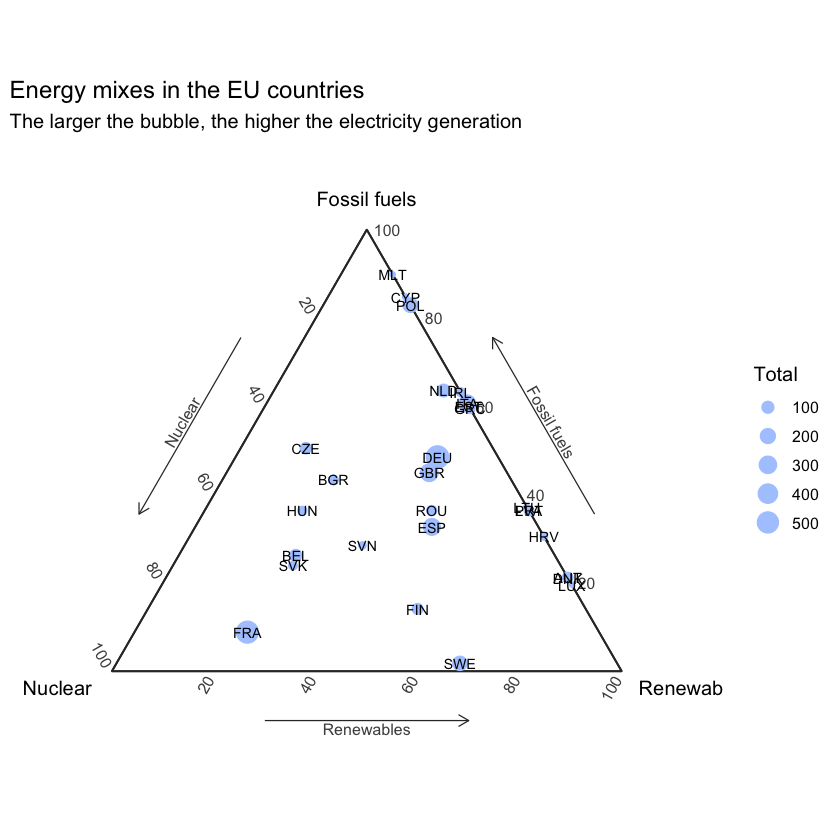

In [100]:
# Generate ternary plot as of 2021, leave out EU-27 as a whole.
ternary_plot_eu_countries <- filter(electricity_shares, Year == 2021, CountryCode != "EU27") |>
                              ggtern(aes(Nuclear, `Fossil fuels`, Renewables)) +
                              geom_point(aes(size = Total), colour = "#aecaff") +
                              geom_text(aes(label = CountryCode), size = 3) +
                              labs(x = "Nuclear",
                                   y = "Fossil fuels",
                                   z = "Renewables",
                                   title = "Energy mixes in the EU countries",
                                   subtitle = "The larger the bubble, the higher the electricity generation") +
                              theme_bw() +
                              theme_nomask() +
                              theme_showarrows()

ternary_plot_eu_countries

In [101]:
# Save the plot as an svg.
svglite::svglite("ternary-plot-eu-countries.svg")
ternary_plot_eu_countries
dev.off()

pdf 
  2

### Possible alterations of the plot

In [ ]:
# Generate ternary plot showing energy transition of a single country.

ternary_plot_cze_path <- filter(electricity_shares, CountryCode == "CZE") |>
                            ggtern(aes(Nuclear, `Fossil fuels`, Renewables)) +
                            geom_point(aes(colour = Year), size = 1) +
                            geom_path(aes(colour = Year)) +
                            labs(x = "Nuclear",
                                    y = "Fossil fuels",
                                    z = "Renewables",
                                    title = "Energy transition in the Czech Republic, 2000–2021") +
                            scale_colour_gradient("Year") +
                            guides(colour = guide_colourbar(barheight = 8, barwidth = 0.5, title.position = "top")) +
                            theme_nomask() +
                            theme_bw() +
                            theme_showarrows()

ternary_plot_cze_path